# i. Perkenalan

**Dataset** : Sephora Products and Skincare Reviews

**Objektif** : Memprediksi apakah seorang pelanggan merekomendasikan produk yang ia beli dari review yang ia tinggalkan di website Sephora

# ii. Import Libraries

In [1]:
import re
import nltk
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from pandas.core.indexers import check_array_indexer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import tensorflow as tf
import tensorflow_hub as tf_hub

from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import json

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
# Filter warnings
warnings.filterwarnings('ignore')

# Tampilkan semua kolom pada dataset
pd.set_option('display.max_columns', None)

# iii. Data Loading

## Setting Kaggle

In [3]:
!mkdir -p /root/.kaggle/

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp '/content/drive/MyDrive/kaggle.json' /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

## Download Dataset

In [6]:
!kaggle datasets download -d nadyinky/sephora-products-and-skincare-reviews

 98% 144M/147M [00:01<00:00, 49.9MB/s]
100% 147M/147M [00:01<00:00, 83.5MB/s]


In [7]:
!unzip /content/sephora-products-and-skincare-reviews.zip -d dataset

Archive:  /content/sephora-products-and-skincare-reviews.zip
  inflating: dataset/product_info.csv  
  inflating: dataset/reviews_0-250.csv  
  inflating: dataset/reviews_1250-end.csv  
  inflating: dataset/reviews_250-500.csv  
  inflating: dataset/reviews_500-750.csv  
  inflating: dataset/reviews_750-1250.csv  


## Load Dataset

In [8]:
# Load Data
data = pd.read_csv('/content/dataset/reviews_0-250.csv')
copy = data.copy()
data

,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602125,602125,7446977307,5,1.0,1.0,12,0,12,2020-12-17,I can’t say enough great things about this pro...,HOLY GRAIL- lash extension safe!!,fair,green,dry,blonde,P467602,Triple Algae Eye Renewal Balm Eye Cream,Algenist,68.0
602126,602126,1991973234,5,1.0,1.0,4,0,4,2020-12-17,I have been using this product for over 6 week...,Game changer!,mediumTan,brown,combination,black,P467602,Triple Algae Eye Renewal Balm Eye Cream,Algenist,68.0
602127,602127,1339171721,5,1.0,1.0,10,0,10,2020-12-17,I love the Triple Algae Eye Renewal Balm! Once...,Triple Algae Eye Renewal Balm is a MUST HAVE,light,hazel,dry,brown,P467602,Triple Algae Eye Renewal Balm Eye Cream,Algenist,68.0
602128,602128,1917233409,5,1.0,1.0,5,0,5,2020-12-17,This made the lines around my eyes so much bet...,NaN,lightMedium,hazel,combination,brown,P467602,Triple Algae Eye Renewal Balm Eye Cream,Algenist,68.0


# iv. Exploratory Data Analysis (EDA)

## Information About Dataset

In [ ]:
# Menampilkan informasi mengenai dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602130 entries, 0 to 602129
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                602130 non-null  int64  
 1   author_id                 602130 non-null  object 
 2   rating                    602130 non-null  int64  
 3   is_recommended            484644 non-null  float64
 4   helpfulness               270298 non-null  float64
 5   total_feedback_count      602130 non-null  int64  
 6   total_neg_feedback_count  602130 non-null  int64  
 7   total_pos_feedback_count  602130 non-null  int64  
 8   submission_time           602130 non-null  object 
 9   review_text               601131 non-null  object 
 10  review_title              435119 non-null  object 
 11  skin_tone                 496074 non-null  object 
 12  eye_color                 463642 non-null  object 
 13  skin_type                 527447 non-null  o

Dataset ini adalah dataset mengenai review dan rating produk yang ada di website Sephora USA. Dataset ini berisi kolom index, id dari user yang memberikan rating/review, rating yang diberikan pelanggan, apakah pelanggan merekomendasikan produk tersebut atau tidak (di mana is_recommended = 1 berarti user merekomendasikan produk tersebut, sementara is_recommended = 0 berarti user tidak merekomendasikan produk tersebut), apakah review membantu user lain (dihitung dari rasio feedback positif yang ditinggalkan user lain), total feedback dari user lain, feedback negatif yang ditinggalkan user lain, feednack positif yang ditinggalkan user lain, tanggal review dibuat, isi dari review, judul review, warna kulit dari user yang memberikan review, warna mata dari user yang memberikan review, jenis kulit dari user yang memberikan review, warna rambut user yang memberikan review, id produk yang dibeli dan di-review user, nama produk yang dibeli dan di-review user, brand dari produk yang dibeli dan di-review user, serta harga produk yang dibeli dan di-review oleh user.

Dari informasi dataset di atas, terlihat beberapa kolom memiliki data yang kosong/missing values, yaitu pada kolom is_recommended, helpfulness, review_text, review_title, skin_tone, eye_color, skin_type, dan hair_color. Hal ini dapat terjadi karena kolom ini merupakan kolom-kolom yang diisi oleh user (kecuali kolom helpfulness) sehingga user dapat mengisi rating namun tidak mengisi informasi lain yang terdapat dalam dataset ini. Sementara kolom helpfulness dihitung dari feedback yang diberikan oleh user lain, sehingga jika tidak ada feedback yang diberikan oleh user lain kolom helpfulness dapat tidak terisi (NaN/null).

Dari dataset ini, akan digunakan kolom is_recommended dan review_text untuk memprediksi apakah user/pelanggan Sephora merekomendasikan produk yang mereka beli/review berdasarkan isi review yang mereka berikan.

### Checking Duplicates

In [9]:
# Cek data duplikat
data.duplicated().sum()

0

Dari hasil pengecekan data yang duplikat, tidak terdapat data yang terduplikat dalam dataset ini sehingga tidak ada data yang perlu di-drop karena merupakan duplikat.

## Handling Missing Values

Dari informasi dataset sebelumnya, terdapat missing values pada kolom is_recommended dan review_text yang akan digunakan pada model prediksi ke depannya.

In [10]:
# Cek missing values
data[data[['is_recommended','review_text']].isnull().any(axis=1)]

,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
8622,8622,5952525178,5,1.0,NaN,0,0,0,2019-09-21,NaN,NaN,tan,green,combination,brunette,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
8686,8686,1647814143,5,1.0,NaN,0,0,0,2019-09-14,NaN,NaN,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
8709,8709,1288462295,5,1.0,NaN,0,0,0,2019-09-13,NaN,NaN,medium,blue,combination,red,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
8748,8748,5172094692,2,0.0,NaN,0,0,0,2019-09-11,NaN,NaN,light,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
8763,8763,6175243190,5,1.0,NaN,0,0,0,2019-09-09,NaN,NaN,fair,brown,oily,brunette,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599834,599834,5967177966,5,NaN,0.888889,9,1,8,2016-03-08,This is the best cleanser I have ever used! It...,Must have!!!,NaN,NaN,NaN,NaN,P405096,SEA Deep Dive Cleansing Gel,tarte,12.0
599835,599835,2852499603,5,NaN,1.000000,31,0,31,2016-03-04,I have never seen a cleanser that takes off ma...,Holy Moly!,NaN,NaN,combination,NaN,P405096,SEA Deep Dive Cleansing Gel,tarte,12.0
599836,599836,1302137119,5,NaN,1.000000,12,0,12,2016-03-04,Leaves my skin squeaky clean! Great product! G...,LOVE,NaN,NaN,NaN,NaN,P405096,SEA Deep Dive Cleansing Gel,tarte,12.0
599837,599837,5288682809,5,NaN,0.888889,9,1,8,2016-03-03,Ok. I am not one to usually leave reviews. HOW...,AMAZING!!!,NaN,NaN,NaN,NaN,P405096,SEA Deep Dive Cleansing Gel,tarte,12.0


Terdapat 118.485 data di mana terdapat missing values pada kolom is_recommended dan kolom review_text. Karena sulit untuk mengimputasi nilai-nilai ini, terutama pada kolom review_text, maka missing values pada kolom-kolom ini akan diimputasi.

In [11]:
# Drop missing values
data = data.dropna(subset=['is_recommended','review_text']).reset_index(drop=True)
data

,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483640,602125,7446977307,5,1.0,1.0,12,0,12,2020-12-17,I can’t say enough great things about this pro...,HOLY GRAIL- lash extension safe!!,fair,green,dry,blonde,P467602,Triple Algae Eye Renewal Balm Eye Cream,Algenist,68.0
483641,602126,1991973234,5,1.0,1.0,4,0,4,2020-12-17,I have been using this product for over 6 week...,Game changer!,mediumTan,brown,combination,black,P467602,Triple Algae Eye Renewal Balm Eye Cream,Algenist,68.0
483642,602127,1339171721,5,1.0,1.0,10,0,10,2020-12-17,I love the Triple Algae Eye Renewal Balm! Once...,Triple Algae Eye Renewal Balm is a MUST HAVE,light,hazel,dry,brown,P467602,Triple Algae Eye Renewal Balm Eye Cream,Algenist,68.0
483643,602128,1917233409,5,1.0,1.0,5,0,5,2020-12-17,This made the lines around my eyes so much bet...,NaN,lightMedium,hazel,combination,brown,P467602,Triple Algae Eye Renewal Balm Eye Cream,Algenist,68.0


## Product Ratings by User Recommendation

<Axes: xlabel='is_recommended', ylabel='rating'>

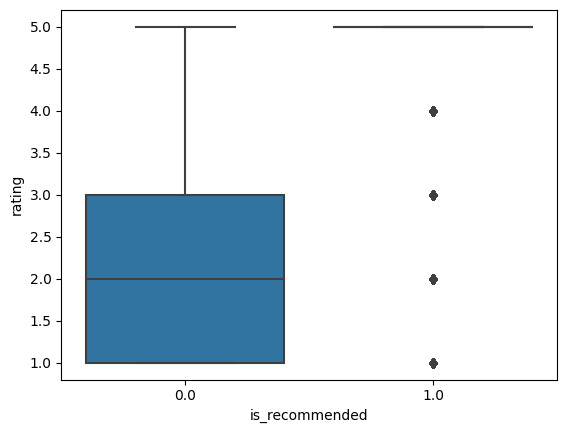

In [ ]:
# Melihat rating produk berdasarkan apakah produk tersebut direkomendasikan menggunakan boxplot
sns.boxplot(x=data['is_recommended'], y=data['rating'])

Dari boxplot rating produk berdasarkan apakah produk tersebut direkomendasikan atau tidak, produk-produk yang tidak direkomendasikan oleh pelanggan memiliki rating yang lebih rendah dibandingkan dengan produk-produk yang direkomendasikan oleh pelanggan. Produk yang tidak direkomendasikan oleh user memiliki rating kurang lebih di antara 1.0 sampai dengan 3.0, sementara produk yang direkomendasikan oleh user sebagian besar memiliki rating 5.0.

## Products Price by User Recommendation

<Axes: xlabel='is_recommended', ylabel='price_usd'>

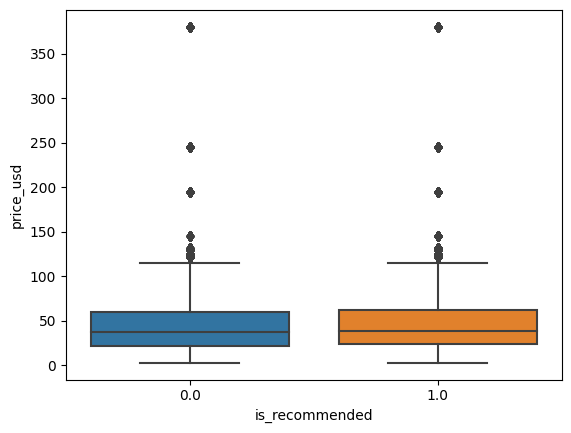

In [ ]:
sns.boxplot(x=data['is_recommended'], y=data['price_usd'])

Dari boxplot harga produk dalam USD berdasarkan apakah produk tersebut direkomendasikan oleh pengguna, tidak ada perbedaan yang jauh antara harga produk yang direkomendasikan oleh user dan produk yang tidak direkomendasikan oleh user. Harga produk berkisar antara 25 USD sampai dengan 60 USD.

## Products Price and Ratings

<Axes: xlabel='rating', ylabel='price_usd'>

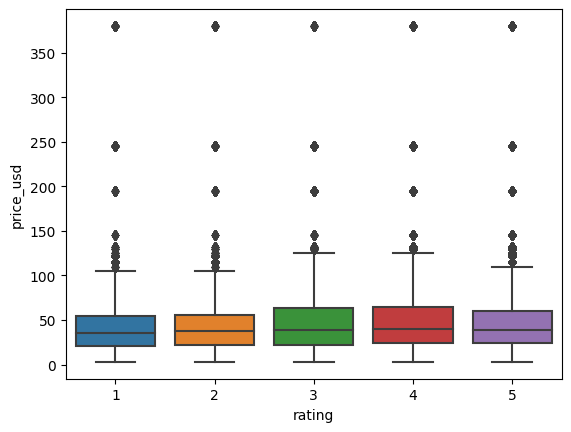

In [ ]:
sns.boxplot(x=data['rating'], y=data['price_usd'])

Dari boxplot harga produk dalam USD berdasarkan rating yang diberikan oleh pengguna, tidak ada perbedaan yang jauh antara rating 1 hingga 5. Produk dengan rating 3 sampai dengan 4 memiliki harga produk yang sedikit lebih mahal dibandingkan produk dengan rating 1, 2, dan 5, namun perbedaannya tidak terlalu besar.

## Review Length

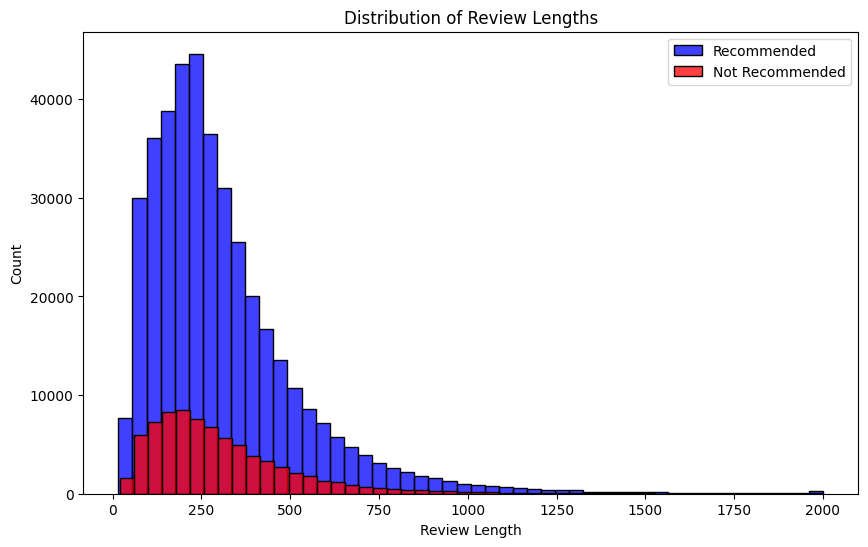

In [ ]:
# Count review length
data['review_length'] = data['review_text'].apply(len)

plt.figure(figsize=(10, 6))

# Plotting review length for recommended products (is_recommended = 1)
sns.histplot(data=data[data['is_recommended'] == 1], x='review_length', bins=50, color='blue', label='Recommended')

# Plotting review length for not recommended products (is_recommended = 0)
sns.histplot(data=data[data['is_recommended'] == 0], x='review_length', bins=50, color='red', label='Not Recommended')

plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.legend()  # Show legend with labels for each category
plt.show()

Dari histogram panjang review di atas, dapat dilihat bahwa panjang review yang diberikan oleh user kurang lebih sepanjang 100 - 300 karakter, di mana tidak ada perbedaan yang terlalu jauh antara panjang review produk yang direkomendasikan oleh pelanggan dengan produk yang tidak direkomendasikan oleh pelanggan. Panjang review dari produk yang direkomendasikan oleh pelanggan sedikit lebih panjang dibandingkan oleh panjang review dari produk yang tidak direkomendasikan oleh pelanggan.

## Most Used Words on Review by User Recommendation

Untuk mengetahui kata apa yang paling sering digunakan oleh pelanggan dalam me-review suatu produk, dapat digunakan word cloud untuk melihat kata mana yang sering muncul dalam review pelanggan. Sebelum word cloud dibuat, terlebih dahulu kata-kata dalam review perlu dibersihkan agar word cloud yang dihasilkan memberikan insight yang lebih akurat.

### Pre-processing Reviews: Checking Mentions and Hashtags

Dalam text review, seharusnya tidak ada mentions dan hashtags seperti dalam text tweet Twitter atau caption Instagram. Namun perlu dicek terlebih dahulu apakah ada mention dan hashtag dalam text review.

In [22]:
# Mencari mention dalam review_text
data['review_text'].loc[data['review_text'].str.contains(r"@[A-Za-z0-9_]+")].to_frame()

,review_text
1978,Happy beyond belief that I gave this product a...
4681,i gave this 3 stars ONLY because i didn’t get ...
9805,"Amazing!!! The smell of the product, packaging..."
9840,Received from Influenster for an honest review...
9883,I received @laneigeca Lip Sleeping Mask in Gra...
...,...
478994,AMAZING!!!So excited to try the new Genius Sle...
480596,I love this lip balm! It is so hydrating and e...
482149,I received this new lip treatment gifted by F...
482188,Gifted by FreshI love this @freshbeauty Peony ...


Terdapat teks review yang memiliki mention, dan sebagian besar mention adalah mention kepada brand yang dibeli atau influencer yang memberikan rekomendasi produk tersebut kepada user. Sehingga informasi ini dapat dihilangkan pada tahap text pre-processing.

In [25]:
# Mencari hashtag dalam review_text
data['review_text'].loc[data['review_text'].str.contains(r"#[A-Za-z0-9_]+")].to_frame()

,review_text
57,Love it!!!! Use it every night and it keeps my...
599,"Speaking strictly on scent here, the Mango is ..."
624,Everyone raves about this balm but I am not im...
1348,"#1 lip mask! I have super dry lips, struggled ..."
2542,"I had high hopes for this product, but was qui..."
...,...
482412,This made my lips feel so moisturized througho...
483113,Depuffs and reduces dark circles is exactly wh...
483240,Just got free sample love it would definitely ...
483381,I received a sample of this product from #pinc...


Dari pengecekan di atas dapat dilihat bahwa terdapat teks review yang memiliki hashtag di dalamnya. (belom kepikiran kenapa harus didrop)

Dari hasil pengecekan mention dan hashtag di atas, maka fungsi text pre-processing adalah sebagai berikut:

In [12]:
# Pre-processing reviews

# List jenis kulit dari user (unique values dari skin_type)
skin_types = [type for type in data['skin_type'].unique() if pd.notnull(type)]

# Mendefinisikan stopwords
stopwords_en = set(stopwords.words('english'))
stopwords_en.add('sephora') # Menambahkan kata Sephora ke dalam stopwords
stopwords_en.add('skin') # Menambahkan kata skin ke dalam stopwords
stopwords_en.update(map(str.lower, data['product_name'].unique())) # Menambahkan nama produk ke dalam stopwords
stopwords_en.update(map(str.lower, data['brand_name'].unique())) # Menambahkan nama brand ke dalam stopwords
stopwords_en.update(map(str.lower, skin_types)) # Menambahkan jenis kulit user ke dalam stopwords

# Mendefiniskan lemmatizer
lemmatizer = WordNetLemmatizer()

# Membuat fungsi untuk memproses text

def text_preprocessing(text, stop_words, lemmatizer):

    # Case folding
    text = text.lower()

    # Menghapus mention dan hashtag
    text = re.sub(r"@[A-Za-z0-9_]+|#[A-Za-z0-9_]+", " ", text)

    # Menghapus baris baru
    text = re.sub(r"\\n", " ", text)

    # Menghapus URL dan special characters
    text = re.sub(r"http\S+|www.\S+|[^A-Za-z\s']", " ", text)

    # Tokenization
    tokens = word_tokenize(text)

    # Menghapus stopwords
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Lemmatization untuk mengembalikan kata menjadi bentuk dasarnya
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Menggabungkan tokens
    processed_text = ' '.join(tokens)

    return processed_text

# Mengaplikasikan fungsi text preprocessing pada review_text
data['review_processed'] = data.apply(lambda row: text_preprocessing(row['review_text'], stopwords_en, lemmatizer), axis=1)
data

,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd,review_processed
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0,use citrus clean balm make melt double cleanse...
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,bought lip mask reading review hype unfortunat...
2,2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,review title say get excited get bed apply lip...
3,3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,always loved formula long time honestly even u...
4,4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,cracked lip must week use learned always bedsi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483640,602125,7446977307,5,1.0,1.0,12,0,12,2020-12-17,I can’t say enough great things about this pro...,HOLY GRAIL- lash extension safe!!,fair,green,dry,blonde,P467602,Triple Algae Eye Renewal Balm Eye Cream,Algenist,68.0,say enough great thing product night shift nur...
483641,602126,1991973234,5,1.0,1.0,4,0,4,2020-12-17,I have been using this product for over 6 week...,Game changer!,mediumTan,brown,combination,black,P467602,Triple Algae Eye Renewal Balm Eye Cream,Algenist,68.0,using product week seen significant difference...
483642,602127,1339171721,5,1.0,1.0,10,0,10,2020-12-17,I love the Triple Algae Eye Renewal Balm! Once...,Triple Algae Eye Renewal Balm is a MUST HAVE,light,hazel,dry,brown,P467602,Triple Algae Eye Renewal Balm Eye Cream,Algenist,68.0,love triple algae eye renewal balm put actuall...
483643,602128,1917233409,5,1.0,1.0,5,0,5,2020-12-17,This made the lines around my eyes so much bet...,NaN,lightMedium,hazel,combination,brown,P467602,Triple Algae Eye Renewal Balm Eye Cream,Algenist,68.0,made line around eye much better also made eye...


### Most Used Words on Recommended Products' Reviews

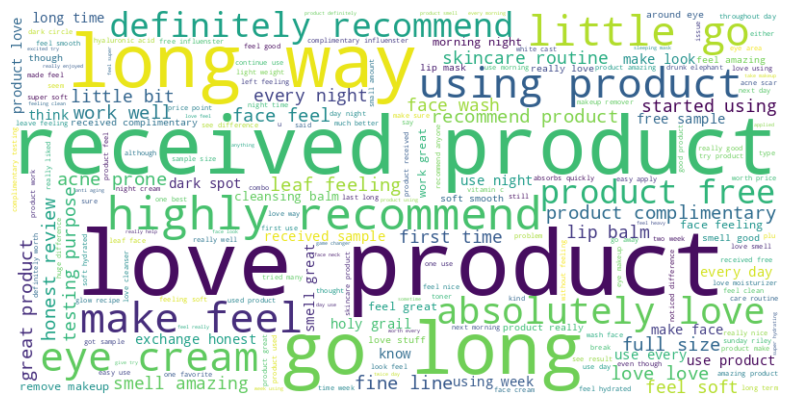

In [13]:
# Word cloud untuk produk yang direkomendasikan oleh user
review_1 = data['review_processed'][data['is_recommended'] == 1].str.cat(sep=' ')
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(review_1)

# Menggambarkan word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')
plt.show()

Dari word cloud review produk-produk yang direkomendasikan oleh user, kata yang sering muncul merupakan kata-kata yang bersifat positif seperti love (the) product, great product, highly recommend, dan definitely recommend. Kata-kata yang sering muncul cukup merepresentasikan kesan positif dari produk-produk yang direkomendasikan oleh user, sehingga text pre-processing sudah cukup baik untuk produk yang direkomendasikan oleh user.

### Most Used Words on Not Recommended Products' Reviews

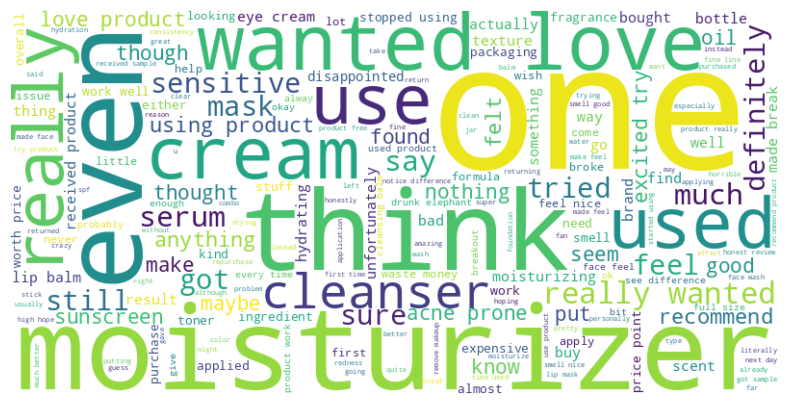

In [14]:
# Word cloud untuk produk yang tidak direkomendasikan user
review_0 = data['review_processed'][data['is_recommended'] == 0].str.cat(sep=' ')
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(review_0)

# Menggambarkan word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.show()

Dari word cloud review produk-produk yang tidak direkomendasikan oleh user, sebagian besar kata yang muncul adalah jenis produknya seperti moisturizer dan cleanser, kata think, really, even, dan one. Kata think bisa berasal dari frasa 'I think... (saya pikir/saya rasa)', sementara kata even bisa berarti walaupun. Kata wanted (to) love juga menjadi kata yang sering muncul, menandakan bahwa user sebenarnya ingin menyukai produk yang tidak mereka rekomendasikan.

Text pre-processing untuk review produk yang tidak direkomendasikan kurang menunjukkan frasa/kata yang berkonotasi negatif seperti disappointed, issue, problem, dan waste (of) money. Kata-kata ini ada di dalam word cloud tetapi tidak muncul sesering kata-kata yang sudah dibahas sebelumnya karena ukuran teks dari kata-kata yang bernada negatif lebih kecil dari kata moisturizer atau cleanser.

Maka untuk meningkatkan akurasi prediksi rekomendasi produk berdasarkan review yang ditinggalkan user, akan ditambahkan jenis produk ke dalam stopwords.

# v. Feature Engineering

## Feature Selection

Untuk memprediksi apakah user merekomendasikan produk yang dibeli berdasarkan review-nya, maka hanya digunakan kolom is_recommended dan review_text.

In [12]:
# Feature selection
data = data[['is_recommended','review_text']]
data

,is_recommended,review_text
0,1.0,I use this with the Nudestix “Citrus Clean Bal...
1,0.0,I bought this lip mask after reading the revie...
2,1.0,My review title says it all! I get so excited ...
3,1.0,I’ve always loved this formula for a long time...
4,1.0,"If you have dry cracked lips, this is a must h..."
...,...,...
483640,1.0,I can’t say enough great things about this pro...
483641,1.0,I have been using this product for over 6 week...
483642,1.0,I love the Triple Algae Eye Renewal Balm! Once...
483643,1.0,This made the lines around my eyes so much bet...


## Data Balancing

Data balancing perlu dilakukan apabila kolom target, yaitu is_recommended, memiliki jumlah data yang berbeda antar kelas. Balancing perlu dilakukan agar model dapat mempelajari kedua kelas secara baik.

In [16]:
# Cek balance kolom target
data['is_recommended'].value_counts()

1.0    405235
0.0     78410
Name: is_recommended, dtype: int64

Dari jumlah unique values kolom is_recommended di atas, dapat dilihat kelas 1.0 atau data produk yang direkomendasikan jauh lebih banyak dibandingkan dengan data produk yang tidak direkomendasikan atau kelas 0.0.

Untuk menyeimbangkan data, maka akan dilakukan under sampling dengan cara mengambil secara acak 5000 data produk yang direkomendasikan dan 5000 data yang tidak direkomendasikan.

In [13]:
# Balancing Data
df_0 = data[data['is_recommended'] == 0].reset_index(drop=True)
df_1 = data[data['is_recommended'] == 1].reset_index(drop=True)

df_0 = df_0.sample(5000,random_state=62).reset_index(drop=True)
df_1 = df_1.sample(5000,random_state=62).reset_index(drop=True)

df = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

df

,is_recommended,review_text
0,0.0,What you’re seeing and feeling is NOT your dea...
1,0.0,"Didnt do anything. I really wanted it to work,..."
2,0.0,So I got this for free to try. Wow it’s expens...
3,0.0,I’m a bit surprised by all the reviews calling...
4,0.0,Meh. I received this product for free from Inf...
...,...,...
9995,1.0,"I have extremely oily skin, so I always have t..."
9996,1.0,I’ve used this eye cream in the past and I sta...
9997,1.0,Looking for something that will help rescue yo...
9998,1.0,It took about 2 whole weeks for my skin to get...


## Text Pre-processing

Untuk memproses teks review, akan digunakan fungsi text pre-processing yang sudah digunakan untuk membuat word cloud pada bagian EDA. Namun, akan ditambahkan jenis produk yang sering muncul pada word cloud sebelumnya. Hal ini dilakukan untuk membuat kata-kata yang diproses dalam model lebih merepresentasikan apakah user merekomendasikan produk yang di-review atau tidak.

In [14]:
# List jenis kulit dari user (unique values dari skin_type)
skin_types = [type for type in copy['skin_type'].unique() if pd.notnull(type)]

# List jenis produk yang muncul pada word cloud
product_types = ['face wash','cleansing balm', 'balm','eye cream','night cream', 'moisturizer','cream','serum','lip balm',
                 'mask','cleanser','sunscreen']

# Mendefinisikan stopwords
stopwords_en = set(stopwords.words('english'))
stopwords_en.add('sephora') # Menambahkan kata Sephora ke dalam stopwords
stopwords_en.add('skin') # Menambahkan kata skin ke dalam stopwords
stopwords_en.update(map(str.lower, copy['product_name'].unique())) # Menambahkan nama produk ke dalam stopwords
stopwords_en.update(map(str.lower, copy['brand_name'].unique())) # Menambahkan nama brand ke dalam stopwords
stopwords_en.update(map(str.lower, skin_types)) # Menambahkan jenis kulit user ke dalam stopwords
stopwords_en.update(map(str.lower, product_types)) # Menambahkan jenis produk yang muncul pada word cloud dalam stopwords

# Mendefiniskan lemmatizer
lemmatizer = WordNetLemmatizer()

In [15]:
# Membuat fungsi untuk memproses text

def text_preprocessing(text, stop_words, lemmatizer):

    # Case folding
    text = text.lower()

    # Menghapus mention dan hashtag
    text = re.sub(r"@[A-Za-z0-9_]+|#[A-Za-z0-9_]+", " ", text)

    # Menghapus baris baru
    text = re.sub(r"\\n", " ", text)

    # Menghapus URL dan special characters
    text = re.sub(r"http\S+|www.\S+|[^A-Za-z\s']", " ", text)

    # Tokenization
    tokens = word_tokenize(text)

    # Menghapus stopwords
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Lemmatization untuk mengembalikan kata menjadi bentuk dasarnya
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Menggabungkan tokens
    processed_text = ' '.join(tokens)

    return processed_text

In [16]:
# Mengaplikasikan fungsi text preprocessing pada review_text
df['review_text'] = df.apply(lambda row: text_preprocessing(row['review_text'], stopwords_en, lemmatizer), axis=1)
df

,is_recommended,review_text
0,0.0,seeing feeling dead product chemically reacts ...
1,0.0,didnt anything really wanted work week differe...
2,0.0,got free try wow expensive something cheaper b...
3,0.0,bit surprised review calling lightweight exper...
4,0.0,meh received product free influenster super ex...
...,...,...
9995,1.0,extremely always trouble finding leave zone lo...
9996,1.0,used eye past started using obsessed sensitive...
9997,1.0,looking something help rescue lip leaving litt...
9998,1.0,took whole week get used product get bunch pim...


## Split X and y

In [17]:
X = df['review_text']
y = df['is_recommended']

## Split Train, Validation, Test

In [18]:
# Data Splitting

X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.20,
                                                            random_state=7,
                                                            stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=88,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (7200,)
Val Size   :  (800,)
Test Size  :  (2000,)


## Text Vectorization

Text vectorization dilakukan untuk mengubah tiap vocabulary menjadi vector agar lebih mudah dipelajari oleh model.

In [19]:
# Mencari vocabulary dengan CountVectorizer

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<7200x7749 sparse matrix of type '<class 'numpy.int64'>'
	with 169338 stored elements in Compressed Sparse Row format>

In [28]:
# Mencari jumlah vocabulary dan panjang maksimum suatu kalimat (token)

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocabularies : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocabularies :  7749
Maximum Sentence Length :  181 tokens


In [21]:
# Text Vectorization

text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,))

text_vectorization.adapt(X_train)

## Word Embedding

Embedding dilakukan untuk memberikan bobot pada tiap kata, dengan tujuan kata yang mirip atau memiliki arti yang mirip memiliki jarak yang dekat antara satu sama lain. Hal ini dilakukan agar model mempelajari kata lebih mudah, dengan mengetahui kata mana saja yang mirip antara satu dengan yang lain.

In [22]:
# Embedding

embedding = Embedding(input_dim=total_vocab,
                            output_dim=100,
                            input_length=max_sen_len)

# vi. Model Definition

Untuk memprediksi apakah user merekomendasikan produk yang mereka review di website Sephora, akan digunakan 4 model untuk mempelajari dataset yang sudah diolah, yaitu 2 model LSTM (Long Short-Term Memory), 1 model Simple RNN (Recurrent Neural Network), dan 1 model GRU (Gated Recurrent Unit).

## LSTM - 1

In [24]:
# Model LSTM - 1
%%time

seed = 20
np.random.seed(seed)
tf.random.set_seed(seed)

## Arsitektur
lstm_1 = Sequential()
lstm_1.add(text_vectorization)
lstm_1.add(embedding)
lstm_1.add(Bidirectional(LSTM(50, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
lstm_1.add(Dropout(0.1))
lstm_1.add(Bidirectional(LSTM(25, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
lstm_1.add(Dropout(0.1))
lstm_1.add(Dense(1, activation='sigmoid'))

# Compile
lstm_1.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

# Summary
lstm_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 181)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 181, 100)          774900    
                                                                 
 bidirectional (Bidirection  (None, 181, 100)          60400     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 181, 100)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 50)                25200     
 onal)                                                           
                                                        

## LSTM - 2

In [25]:
# Model LSTM - 2
%%time

seed = 20
np.random.seed(seed)
tf.random.set_seed(seed)

# Arsitektur
lstm_2 = Sequential()
lstm_2.add(text_vectorization)
lstm_2.add(embedding)
lstm_2.add(Bidirectional(LSTM(10, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
lstm_2.add(Dropout(0.4))
lstm_2.add(Bidirectional(LSTM(10, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
lstm_2.add(Dropout(0.4))
lstm_2.add(Dense(1, activation='sigmoid'))

# Compile
lstm_2.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

# Summary
lstm_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 181)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 181, 100)          774900    
                                                                 
 bidirectional_2 (Bidirecti  (None, 181, 20)           8880      
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 181, 20)           0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 20)                2480      
 onal)                                                           
                                                      

## SimpleRNN

In [37]:
# Model Simple RNN
%%time

seed = 20
np.random.seed(seed)
tf.random.set_seed(seed)

# Arsitektur
rnn = Sequential()
rnn.add(text_vectorization)
rnn.add(embedding)
rnn.add(Bidirectional(SimpleRNN(10, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
rnn.add(Dropout(0.4))
rnn.add(Bidirectional(SimpleRNN(10, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
rnn.add(Dropout(0.4))
rnn.add(Dense(1, activation='sigmoid'))

# Compile
rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

# Summary
rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 181)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 181, 100)          774900    
                                                                 
 bidirectional_4 (Bidirecti  (None, 181, 20)           2220      
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 181, 20)           0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 20)                620       
 onal)                                                           
                                                      

## GRU

In [38]:
# Model GRU
%%time

seed = 20
np.random.seed(seed)
tf.random.set_seed(seed)

# Arsitektur
gru = Sequential()
gru.add(text_vectorization)
gru.add(embedding)
gru.add(Bidirectional(GRU(10, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
gru.add(Dropout(0.4))
gru.add(Bidirectional(GRU(10, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
gru.add(Dropout(0.4))
gru.add(Dense(1, activation='sigmoid'))

# Compile
gru.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

# Summary
gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 181)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 181, 100)          774900    
                                                                 
 bidirectional_6 (Bidirecti  (None, 181, 20)           6720      
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 181, 20)           0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 20)                1920      
 onal)                                                           
                                                      

# vii. Model Training

## LSTM - 1

Model LSTM 1 dan 2 selain dibedakan dari jumlah neuron pada hidden layer dan besar dropout yang dikenakan pada neuron hidden layer juga dibedakan dengan ada dan tidak adanya callback. Pada model LSTM 1, model akan di-training tanpa menggunakan fungsi callback.

In [48]:
# Training model LSTM 1

lstm_hist = lstm_1.fit(X_train, y_train, epochs=50, batch_size=125, validation_data=(X_val, y_val))

Epoch 1/50
58/58 [==============================] - 36s 515ms/step - loss: 0.3810 - accuracy: 0.8438 - val_loss: 0.3932 - val_accuracy: 0.8487
Epoch 2/50
58/58 [==============================] - 28s 487ms/step - loss: 0.1608 - accuracy: 0.9521 - val_loss: 0.4233 - val_accuracy: 0.8325
Epoch 3/50
58/58 [==============================] - 28s 488ms/step - loss: 0.1216 - accuracy: 0.9676 - val_loss: 0.4953 - val_accuracy: 0.8325
Epoch 4/50
58/58 [==============================] - 28s 490ms/step - loss: 0.0980 - accuracy: 0.9747 - val_loss: 0.5226 - val_accuracy: 0.8413
Epoch 5/50
58/58 [==============================] - 28s 489ms/step - loss: 0.0862 - accuracy: 0.9786 - val_loss: 0.5620 - val_accuracy: 0.8275
Epoch 6/50
58/58 [==============================] - 28s 492ms/step - loss: 0.0816 - accuracy: 0.9799 - val_loss: 0.5677 - val_accuracy: 0.8363
Epoch 7/50
58/58 [==============================] - 28s 488ms/step - loss: 0.0642 - accuracy: 0.9849 - val_loss: 0.5918 - val_accuracy: 0.8300

## LSTM - 2

Model LSTM 2 akan menggunakan callback dalam training modelnya. Callback yang digunakan dalam training model LSTM 2 adalah Early Stopping, di mana callback ini akan menghentikan epoch ketika sudah mencapai target dari metrics yang dimonitor dengan lag (patience) sesuai dengan yang ditentukan, dan Model Checkpoint, yaitu callback yang berfungsi untuk menyimpan epoch dengan metrics yang dimonitor sudah mencapai yang terbaik.

Apabila metrics yang dimonitor merupakan accuracy (atau metrics classification/regression lainnya) maka metrics yang diambil yang paling maksimum. Sementara apabila metrics yang dimonitor merupakan loss, maka metrics yang diambil yang paling minimum.

In [26]:
# Callback
callbacks = [
    # Early Stopping
    EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True),

    # Model Checkpoint
    ModelCheckpoint('model_lstm_2', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_format='tf')
]

# Training model LSTM 2
lstm2_hist = lstm_2.fit(X_train, y_train, epochs=50, batch_size=125, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/50
58/58 [==============================] - ETA: 0s - loss: 0.6457 - accuracy: 0.6765
Epoch 1: val_accuracy improved from -inf to 0.79625, saving model to model_lstm_2
58/58 [==============================] - 69s 1s/step - loss: 0.6457 - accuracy: 0.6765 - val_loss: 0.5212 - val_accuracy: 0.7962
Epoch 2/50
58/58 [==============================] - ETA: 0s - loss: 0.4286 - accuracy: 0.8635
Epoch 2: val_accuracy improved from 0.79625 to 0.85500, saving model to model_lstm_2
58/58 [==============================] - 49s 856ms/step - loss: 0.4286 - accuracy: 0.8635 - val_loss: 0.4037 - val_accuracy: 0.8550
Epoch 3/50
58/58 [==============================] - ETA: 0s - loss: 0.3088 - accuracy: 0.9046
Epoch 3: val_accuracy improved from 0.85500 to 0.85625, saving model to model_lstm_2
58/58 [==============================] - 49s 854ms/step - loss: 0.3088 - accuracy: 0.9046 - val_loss: 0.3821 - val_accuracy: 0.8562
Epoch 4/50
58/58 [==============================] - ETA: 0s - loss: 0.274

## Simple RNN

Model RNN akan di-training menggunakan callback, seperti pada model LSTM 2.

In [40]:
# Callback
callbacks = [
    # Early Stopping
    EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True),

    # Model Checkpoint
    ModelCheckpoint('model_rnn', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_format='tf')
]

# Training model Simple RNN
rnn_hist = rnn.fit(X_train, y_train, epochs=50, batch_size=125, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/50
58/58 [==============================] - ETA: 0s - loss: 0.6606 - accuracy: 0.6024
Epoch 1: val_accuracy improved from -inf to 0.74250, saving model to model_rnn
58/58 [==============================] - 15s 226ms/step - loss: 0.6606 - accuracy: 0.6024 - val_loss: 0.5852 - val_accuracy: 0.7425
Epoch 2/50
58/58 [==============================] - ETA: 0s - loss: 0.4780 - accuracy: 0.8168
Epoch 2: val_accuracy improved from 0.74250 to 0.78125, saving model to model_rnn
58/58 [==============================] - 14s 241ms/step - loss: 0.4780 - accuracy: 0.8168 - val_loss: 0.4930 - val_accuracy: 0.7812
Epoch 3/50
58/58 [==============================] - ETA: 0s - loss: 0.3524 - accuracy: 0.8907
Epoch 3: val_accuracy improved from 0.78125 to 0.83000, saving model to model_rnn
58/58 [==============================] - 13s 220ms/step - loss: 0.3524 - accuracy: 0.8907 - val_loss: 0.4323 - val_accuracy: 0.8300
Epoch 4/50
58/58 [==============================] - ETA: 0s - loss: 0.2760 - ac

## GRU

Model GRU akan di-training menggunakan callback, seperti pada model LSTM 2 dan Simple RNN.

In [41]:
# Callback
callbacks = [
    # Early Stopping
    EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True),

    # Model Checkpoint
    ModelCheckpoint('model_gru', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_format='tf')
]

# Training model GRU
gru_hist = gru.fit(X_train, y_train, epochs=50, batch_size=125, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/50
58/58 [==============================] - ETA: 0s - loss: 0.6026 - accuracy: 0.7296
Epoch 1: val_accuracy improved from -inf to 0.78125, saving model to model_gru
58/58 [==============================] - 34s 485ms/step - loss: 0.6026 - accuracy: 0.7296 - val_loss: 0.4957 - val_accuracy: 0.7812
Epoch 2/50
58/58 [==============================] - ETA: 0s - loss: 0.3387 - accuracy: 0.8781
Epoch 2: val_accuracy improved from 0.78125 to 0.82625, saving model to model_gru
58/58 [==============================] - 26s 455ms/step - loss: 0.3387 - accuracy: 0.8781 - val_loss: 0.4142 - val_accuracy: 0.8263
Epoch 3/50
58/58 [==============================] - ETA: 0s - loss: 0.2095 - accuracy: 0.9350
Epoch 3: val_accuracy improved from 0.82625 to 0.83625, saving model to model_gru
58/58 [==============================] - 27s 465ms/step - loss: 0.2095 - accuracy: 0.9350 - val_loss: 0.4220 - val_accuracy: 0.8363
Epoch 4/50
58/58 [==============================] - ETA: 0s - loss: 0.1595 - ac

# viii. Model Evaluation

## Training Accuracy and Loss

### LSTM - 1

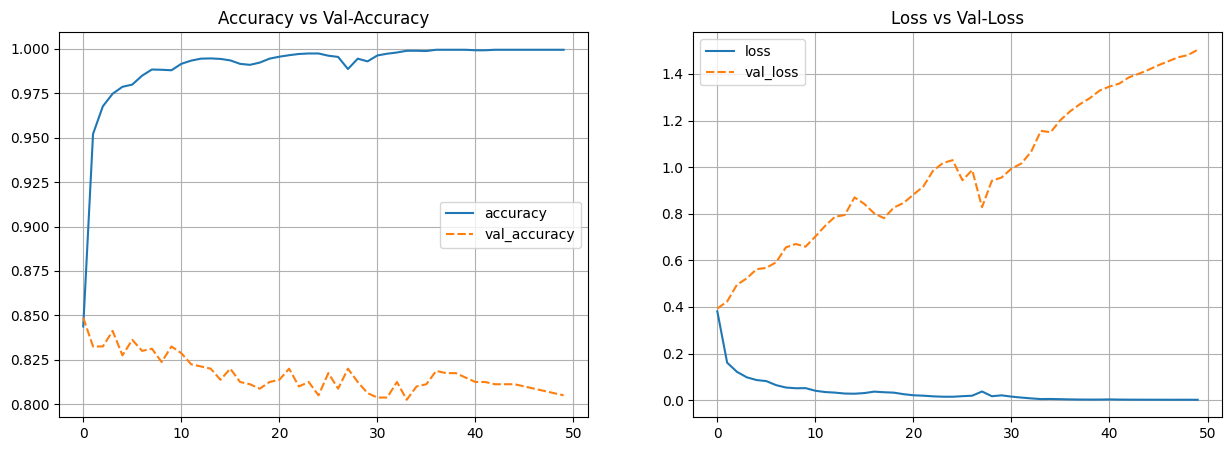

In [49]:
# Plot Hasil Training LSTM 1

lstm_hist_df = pd.DataFrame(lstm_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=lstm_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=lstm_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

Hasil training dari model LSTM 1 menunjukkan bahwa model tergolong overfitting, di mana accuracy dan loss dari train set jauh lebih tinggi dibandingkan dengan accuracy dan loss dari validation set. Dari plot hasil training, hanya beberapa epoch awal yang tidak overfitting. Namun karena tidak menggunakan Model Checkpoint, maka model yang di-save merupakan model paling terakhir dengan accuracy pada validation set berkisar pada 0.80.

### LSTM - 2

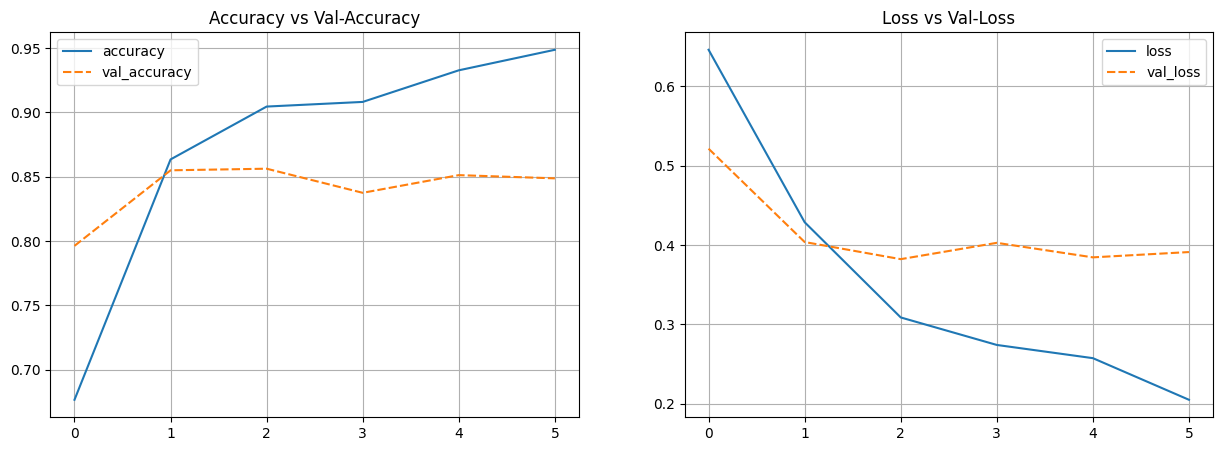

In [29]:
# Plot Hasil Training LSTM 2

lstm2_hist_df = pd.DataFrame(lstm2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=lstm2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=lstm2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

Hasil training dari model LSTM 2 menunjukkan bahwa model masih tergolong sedikit overfitting, namun overfitting sudah jauh berkurang dibandingkan dengan model LSTM 1. Performa dari accuracy dan loss model LSTM 2 mungkin hampir sama dengan beberapa epoch pertama pada model LSTM 1, namun model LSTM 2 memiliki performa yang lebih tidak overfit dan sudah di-save menggunakan Model Checkpoint pada accuracy di validation set yang paling tinggi.

### Simple RNN

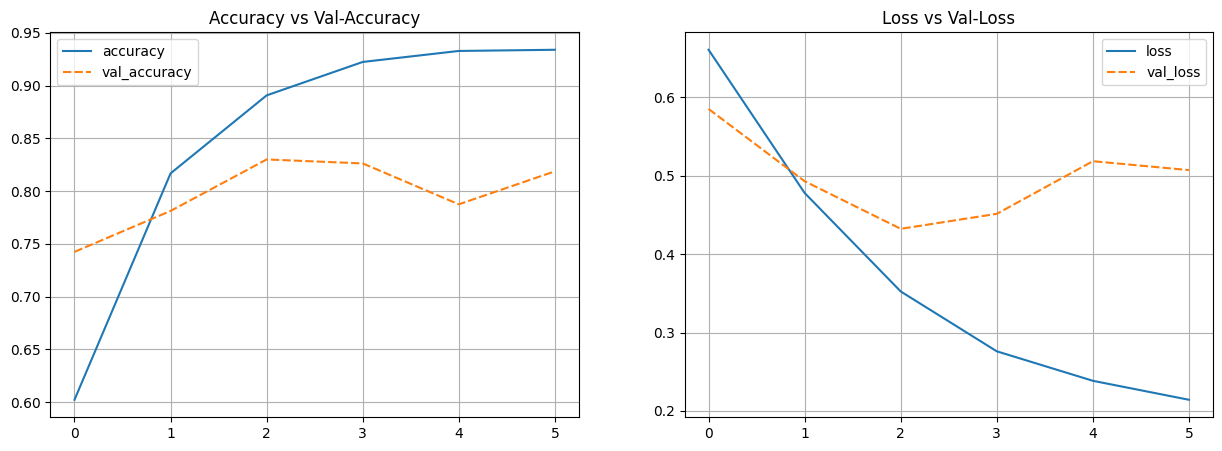

In [43]:
# Plot Hasil Training Simple RNN

rnn_hist_df = pd.DataFrame(rnn_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=rnn_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=rnn_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

Hasil training model RNN dengan menggunakan callback menunjukkan bahwa overfitting pada model jauh berkurang dibandingkan dengan model LSTM 1 yang tidak menggunakan callback pada saat model training. Namun jika dibandingkan dengan model LSTM 2, model LSTM 2 memiliki hasil yang lebih baik. Pada model RNN, accuracy pada validation set berkisar antara 0.75 - 0.81 dan loss berkisar antara 0.5 - 0.6. Sementara pada model LSTM 2 accuracy pada validation set berkisar antara 0.80 - 0.85 dan loss antara 0.38 - 0.52.

### GRU

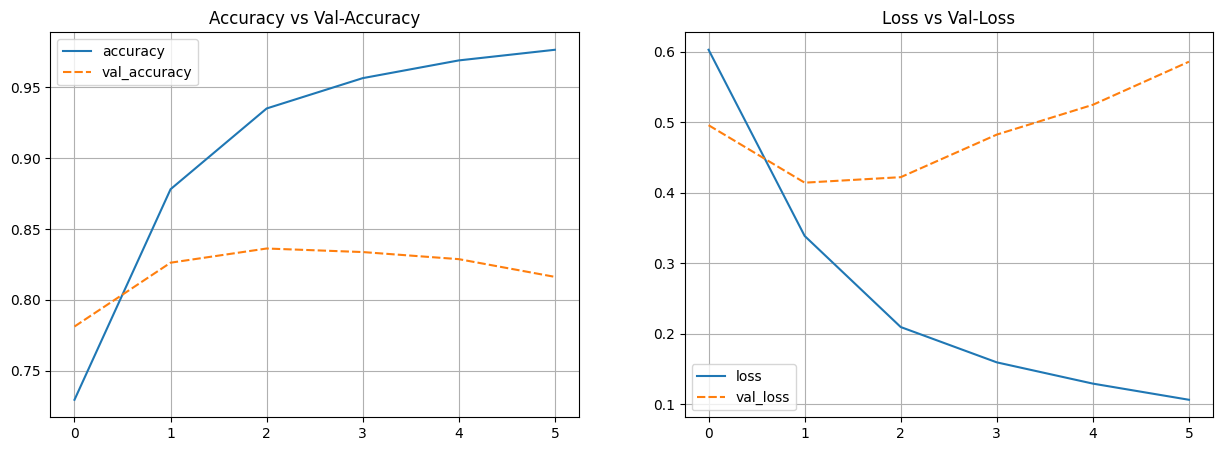

In [44]:
# Plot Hasil Training GRU

gru_hist_df = pd.DataFrame(gru_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=gru_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=gru_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

Hasil training dari model GRU menunjukkan bahwa model GRU lebih tidak overfitting dibandingkan dengan model LSTM 1 yang tidak menggunakan callback pada saat training model, namun lebih overfitting dibandingkan dengan model LSTM 2 dan model Simple RNN yang juga menggunakan callback. Secara performa, model GRU sedikit lebih baik namun hampir sama dengan model Simple RNN. Model GRU memiliki accuracy pada validation set antara 0.78 - 0.81 dan loss antara 0.42 - 0.59.

## Model Evaluation on Test Set

### LSTM - 1

In [50]:
# Evaluasi model LSTM 1 pada test set
result_lstm1 = lstm_1.evaluate(X_test,y_test)

63/63 [==============================] - 3s 46ms/step - loss: 1.5151 - accuracy: 0.8170


Model LSTM 1 memprediksi test set dengan accuracy sebesar 0.81 dan loss 1.51

### LSTM - 2

In [30]:
# Evaluasi model LSTM 2 pada test set
result_lstm2 = lstm_2.evaluate(X_test,y_test)

63/63 [==============================] - 3s 46ms/step - loss: 0.4202 - accuracy: 0.8435


Model LSTM 2 memprediksi test set dengan accuracy sebesar 0.84 dan loss 0.42

### Simple RNN

In [46]:
# Evaluasi model Simple RNN pada test set
result_rnn = rnn.evaluate(X_test,y_test)

63/63 [==============================] - 1s 18ms/step - loss: 0.4709 - accuracy: 0.8065


Model Simple RNN memprediksi test set dengan accuracy sebesar 0.80 dan loss 0.47

### GRU

In [47]:
# Evaluasi model GRU pada test set
result_gru = gru.evaluate(X_test,y_test)

63/63 [==============================] - 2s 25ms/step - loss: 0.4779 - accuracy: 0.8130


Model GRU memprediksi test set dengan accuracy sebesar 0.81 dan loss 0.47

## Final Model

Dari hasil evaluasi model sebelumnya, maka akan digunakan model LSTM 2 untuk memprediksi apakah pelanggan merekomendasikan produk yang mereka review di website Sephora. Model LSTM 2 dipilih karena merupakan model yang paling tidak overfitting dan memiliki accuracy dan loss yang paling baik dibandingkan dengan 3 model lainnya.

In [31]:
# Memprediksi X test
y_test_pred = lstm_2.predict(X_test)

63/63 [==============================] - 8s 76ms/step


In [42]:
# Mengubah hasil prediksi dari probabilitas menjadi kelas 0 atau 1
y_test_pred_final = np.where(y_test_pred > 0.5, 1, 0)

Classification Report : 
               precision    recall  f1-score   support

         0.0       0.86      0.82      0.84      1000
         1.0       0.83      0.87      0.85      1000

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000


Confusion Matrix      : 


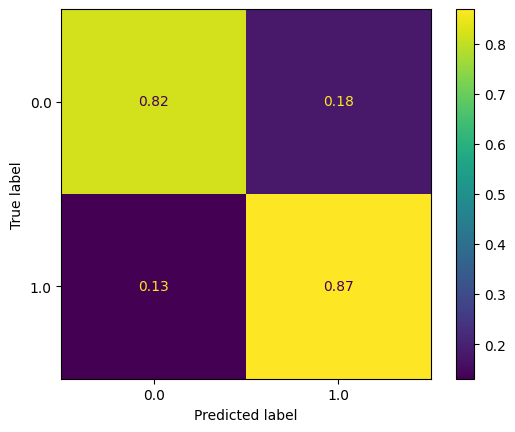

In [43]:
# Classification Report dari Test Set
print('Classification Report : \n', classification_report(y_test, y_test_pred_final))
print('')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                                                            y_pred=y_test_pred_final,
                                                                            normalize='true'))

Berdasarkan classification report dan confusion matrix di atas, model LTSM 2 dapat memprediksi review user yang merekomendasikan produk dengan akurasi 87% dan review user yang tidak merekomendasikan produk yang di-review-nya dengan akurasi 82%.

# ix. Model Saving

Model LTSM 2 sudah di-save dengan menggunakan Model Checkpoint, sehingga folder model LSTM 2 akan dimasukan ke dalam zip untuk di-load pada model inference.

Sementara fungsi text preprocessing disimpan dalam format .py.

In [44]:
# Zip model LSTM 2
!zip -r /content/model_lstm_2.zip /content/model_lstm_2/

  adding: content/model_lstm_2/ (stored 0%)
  adding: content/model_lstm_2/variables/ (stored 0%)
  adding: content/model_lstm_2/variables/variables.index (deflated 64%)
  adding: content/model_lstm_2/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: content/model_lstm_2/saved_model.pb (deflated 89%)
  adding: content/model_lstm_2/fingerprint.pb (stored 0%)
  adding: content/model_lstm_2/keras_metadata.pb (deflated 91%)
  adding: content/model_lstm_2/assets/ (stored 0%)


In [45]:
# Menyimpan list stopwords
with open('stopwords.txt', 'w') as file:
    json.dump(list(stopwords_en), file)

# x. Kesimpulan

Review yang diberikan oleh user Sephora USA dapat memprediksi apakah user tersebut merekomendasikan produk yang di-review atau tidak menggunakan Natural Languange Processing (NLP). Dengan menggunakan model Long Short-Term Memory (LSTM), model dapat memprediksi apakah user merekomedasikan produk yang mereka review dengan akurasi sebesar 84%.

Untuk meningkatkan performa model, dapat digunakan seluruh dataset karena model ini hanya menggunakan sebagian data yang ada karena dilakukannya under sampling. Selain itu, hanya digunakan satu file csv dari 5 file csv, sehingga ada kemungkinan ada produk yang tidak dilihat oleh model. Hal lain yang dapat meningkatkan model adalah mendeteksi apakah review ditinggalkan oleh user yang di-endorse atau disponsori oleh brand yang di-review.